# Using Bayesian Networks in Collaborative Filtering and Content Based Recommendations


In [1]:
import numpy as np
import pandas as pd
import scipy.stats
import time

In [2]:
#load data from CSV
train_user_item_rt = pd.read_csv('train_unn.csv')
test_user_item_rt = pd.read_csv('test_unn.csv')
item_feat_map_old = pd.read_csv('item_feature_matrix_ex_crew.csv')

In [4]:
#Building loading and editing the the item-feature matrix:
user_movie_id = list(train_user_item_rt.columns)

In [5]:
user_movie_id.remove('user_id')

In [6]:
user_movie_id = map(int,user_movie_id)
len(user_movie_id)

9024

In [7]:
item_feat_map = item_feat_map_old.loc[item_feat_map_old['movieId'].isin(user_movie_id)]
item_feat_map.shape

(9024, 97)

In [8]:
del train_user_item_rt['user_id']
del test_user_item_rt['user_id']

In [9]:
del item_feat_map['Unnamed: 0']
del item_feat_map['movieId']

In [10]:
item_feat_map.shape

(9024, 95)

In [11]:
#Replacing NaNs with zeroes
train_user_item_rt = train_user_item_rt.fillna(0)
test_user_item_rt = test_user_item_rt.fillna(0)
item_feat_map = item_feat_map.fillna(0)

In [12]:
#converting DFs to NP Matrices
train_user_item_rt_np= np.array(train_user_item_rt)
test_user_item_rt_np= np.array(test_user_item_rt)
item_feat_map_np= np.array(item_feat_map)

In [13]:
ratings_to_be_predicted = np.argwhere(test_user_item_rt_np != 0)
ratings_to_be_predicted.shape

(19962L, 2L)

Calcultion of the similarity scores of all users using the formula:
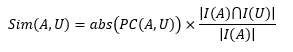

In [14]:
#Finding similarity scores of users
sim_score_array = []
for user in range(train_user_item_rt_np.shape[0]):
    avg_user_rt = np.sum(train_user_item_rt_np, axis=1).astype(float)/np.count_nonzero(train_user_item_rt_np, axis=1)
    temp_check = train_user_item_rt_np >0
    temp_check = temp_check.astype(int)
    avg_rt_2d = (temp_check.T * avg_user_rt).T
    norm_user_item_rt = train_user_item_rt_np - avg_rt_2d

    sim_score = []
    target_user = train_user_item_rt_np[user]
    tar_com = np.sum(temp_check[user])
    for i in range(train_user_item_rt_np.shape[0]):
        corr = scipy.stats.pearsonr(target_user, train_user_item_rt_np[i])[0]
        n_com = np.sum(temp_check[user] * temp_check[i]).astype(float)/tar_com
        sim_score.append(corr * n_com)

    sim_score = np.abs(sim_score)
    sim_score_sum = np.sum(sim_score) - 1
    R_sim_score = sim_score/np.sum(sim_score)
    R_sim_score[user] = 1
    sim_score_array.append(R_sim_score)

sim_score_array = np.array(sim_score_array)

In [54]:
users_sim_score_sum = np.sum(sim_score_array,axis = 0) -1
sim_score_array_users_with_zero_Sim = np.where(users_sim_score_sum == 0)

(78048L, 2L)

Collobarative based recommendation:
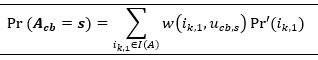

Content based recommendation:
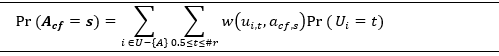
    

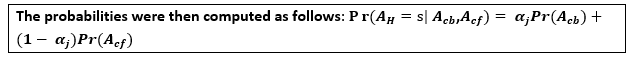


In [16]:
def get_user_item_rating(user_item_rt, item_feat_map, user, item, rating_scale,R_sim_score, alpha):
    rating = rating_scale
    user = user+1
    item=item+1
    
    user_subitems = np.nonzero(user_item_rt[user-1])[0]
    req_item_feat = item_feat_map[user_subitems]
   
    
    pf1 = np.sum(req_item_feat, axis=0) + 0.5
    pf1 /=  (req_item_feat.shape[0] + 1)
    pf1[np.nonzero(item_feat_map[item-1])[0]] = 1
    
    feat_contrib =  np.sum(req_item_feat, axis=0)
    non_zero_feat_index = np.where(feat_contrib)
    
    req_item_feat = (req_item_feat.T[non_zero_feat_index]).T
    
    pf1 = pf1[non_zero_feat_index]  
    
    feat_weight_1d = np.log(float(req_item_feat.shape[0])/np.sum(req_item_feat, axis=0) + 1)
        
    feat_weight_2d = np.reshape(np.tile(feat_weight_1d, req_item_feat.shape[0]), 
                                (req_item_feat.shape[0],req_item_feat.shape[1]))
    feat_weight_2d = np.multiply(req_item_feat, feat_weight_2d)
    feat_weight_2d = feat_weight_2d.T/np.sum(feat_weight_2d, axis=1)
    feat_weight_2d = feat_weight_2d.T
    
    pi1 = np.dot(feat_weight_2d, pf1)
          
    A_cb_weights = np.tile([1.0/len(user_subitems)], len(user_subitems))
    sub_items_rt = user_item_rt[user-1][np.nonzero(user_item_rt[user-1])]
    
    acb_sub = np.multiply(pi1, A_cb_weights)
    
    A_cb = [0] * len(rating)
    for i in range(len(rating)):
        for j in np.where(sub_items_rt== rating[i]):
            A_cb[i] += np.sum(acb_sub[j])
    A_cb = np.array(A_cb)/sub_items_rt.shape[0]
    
    A_cb = A_cb/np.sum(A_cb)
    
    u_minus_user_t = np.argwhere(user_item_rt.T[item-1] == 0).flatten()
    index = np.where(u_minus_user_t== user-1)
    u_minus_user =  np.delete(u_minus_user_t, index)
    u_minus_all_item_rt = user_item_rt[u_minus_user]
    u_minus_rt = u_minus_all_item_rt.T[user_subitems]
    u_minus_rt = u_minus_rt.T
    u_minus_rt_sum = np.count_nonzero(u_minus_rt, axis=1)
    non_zero_users_index = np.where(u_minus_rt_sum)
    u_minus_rt = u_minus_rt[non_zero_users_index]
    u_minus_all_item_rt = u_minus_all_item_rt[non_zero_users_index]
      
    pi1_tile = np.tile(pi1, u_minus_rt.shape[0])
    pi1_tile = np.reshape(pi1_tile, (u_minus_rt.shape[0], u_minus_rt.shape[1]))
    u_minus_pi1 = np.multiply(u_minus_rt, pi1_tile)
    non_zero_count = np.count_nonzero(u_minus_all_item_rt, axis=1)
        
    rt_freq = []
    for i in rating:
        rt_freq.append(list((u_minus_rt == i).sum(axis=1)))
    
    
    u_minus_rt_fre = np.array(rt_freq).T

    user_pred_rt = []
    for i in rating:
        temp_rt = np.zeros_like(u_minus_rt)
        #temp_rt = np.copy(u_minus_rt)
        temp_rt[temp_rt == i] = 1
        user_pred_rt.append(list(np.dot(pi1_tile, temp_rt.T)[0]))
    
    user_pred_rt = np.array(user_pred_rt).T

    user_pred_prob = (user_pred_rt.T/non_zero_count).T
    
    total_users = np.array(range(user_item_rt.shape[0]))
    u_plus_users = np.setdiff1d(total_users, u_minus_user_t)
    u_plus_rt = user_item_rt[u_plus_users]
    u_plus_item_rt = u_plus_rt.T[item-1]
    u_plus_pred = np.zeros((u_plus_users.shape[0], len(rating)))
    
    u_plus_prob = np.zeros_like(u_plus_item_rt)
    idx = np.where(u_plus_item_rt == 0.5)
    u_plus_prob[idx] = 1
    for i in range(1,len(rating)):
        temp = np.zeros_like(u_plus_item_rt)
        idx = np.where(u_plus_item_rt == rating[i])
        temp[idx] = 1
        u_plus_prob = np.vstack((u_plus_prob, temp))

    u_plus_prob = u_plus_prob.T
    
    total_user_prob = np.vstack((u_plus_prob, user_pred_prob))
    
    R_sim_score = np.delete(R_sim_score, user-1)
    
    non_active_users = np.delete(user_item_rt, (user-1), axis=0)
    active_user_rt = user_item_rt[user-1]
    active_user_items = np.where(active_user_rt)
    active_user_items =  np.append(active_user_items, item-1)
    non_active_users_rt_sum = np.sum(non_active_users.T[active_user_items].T, axis=1)
    non_active_users_index =  np.where(non_active_users_rt_sum)[0]
    non_active_users = non_active_users[non_active_users_index]
    
    R_sim_score_curr = R_sim_score[non_active_users_index]
    collab_weight = []
    for i in rating:
        rt_index =  np.where(active_user_rt == i)
        req_set = non_active_users.T[rt_index]
        rt_freq = []
        for j in rating:
            temp = list((req_set.T == j).sum(axis=1))
            rt_freq.append(temp)
        collab_weight.append(np.array(rt_freq).T)

    collab_weight = np.array(collab_weight)
    
    collab_weight = collab_weight + (1.0/5)
    
    user_rt_fre = []
    for i in rating:
        temp = list((non_active_users == i).sum(axis=1))
        user_rt_fre.append(temp)

    user_rt_fre =  np.array(user_rt_fre).T
    user_rt_fre = user_rt_fre + 1
    
    for i in range(len(rating)):
        collab_weight[i] = np.divide(collab_weight[i], user_rt_fre)
        collab_weight[i] = (collab_weight[i].T * R_sim_score_curr).T
    
    A_cf_prob = []
    for i in range(len(rating)):
        temp = np.multiply(collab_weight[i], total_user_prob)
        A_cf_prob.append(np.sum(temp))

    A_cf_prob = np.array(A_cf_prob)
    
    A_cf_prob = A_cf_prob/np.sum(A_cf_prob)
    
    final_prob = (alpha * A_cb) + ((1-alpha) * A_cf_prob)
    pred_rt = np.argmax(final_prob)
    
    return rating[pred_rt]

In [18]:
predicted_ratings = np.zeros_like(test_user_item_rt_np)
ratings =[0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0]
check = 0
for i in range(0,ratings_to_be_predicted.shape[0]):

    user = ratings_to_be_predicted[i][0]
    movie = ratings_to_be_predicted[i][1] 
    predicted_ratings[user][movie] = get_user_item_rating(train_user_item_rt_np,item_feat_map_np,user,movie,ratings,
                                                          sim_score_array[user],0.7)
    if user != check:
        print("user %d",(user)," is complete")
        check = user
   
    

('user %d', 1, ' is complete')
('user %d', 2, ' is complete')
('user %d', 3, ' is complete')
('user %d', 4, ' is complete')
('user %d', 5, ' is complete')
('user %d', 6, ' is complete')
('user %d', 7, ' is complete')


C:\Users\hp\Anaconda2\lib\site-packages\ipykernel_launcher.py:171: RuntimeWarning: invalid value encountered in divide


('user %d', 8, ' is complete')
('user %d', 9, ' is complete')
('user %d', 10, ' is complete')
('user %d', 11, ' is complete')
('user %d', 12, ' is complete')
('user %d', 13, ' is complete')
('user %d', 14, ' is complete')
('user %d', 15, ' is complete')
('user %d', 16, ' is complete')
('user %d', 17, ' is complete')
('user %d', 18, ' is complete')
('user %d', 19, ' is complete')
('user %d', 20, ' is complete')
('user %d', 21, ' is complete')
('user %d', 22, ' is complete')
('user %d', 23, ' is complete')
('user %d', 24, ' is complete')
('user %d', 25, ' is complete')
('user %d', 26, ' is complete')
('user %d', 27, ' is complete')
('user %d', 28, ' is complete')
('user %d', 29, ' is complete')
('user %d', 30, ' is complete')
('user %d', 31, ' is complete')
('user %d', 32, ' is complete')
('user %d', 33, ' is complete')
('user %d', 34, ' is complete')
('user %d', 35, ' is complete')
('user %d', 36, ' is complete')
('user %d', 37, ' is complete')
('user %d', 38, ' is complete')
('user %d'

('user %d', 260, ' is complete')
('user %d', 261, ' is complete')
('user %d', 262, ' is complete')
('user %d', 263, ' is complete')
('user %d', 264, ' is complete')
('user %d', 265, ' is complete')
('user %d', 266, ' is complete')
('user %d', 267, ' is complete')
('user %d', 268, ' is complete')
('user %d', 269, ' is complete')
('user %d', 270, ' is complete')
('user %d', 271, ' is complete')
('user %d', 272, ' is complete')
('user %d', 273, ' is complete')
('user %d', 274, ' is complete')
('user %d', 275, ' is complete')
('user %d', 276, ' is complete')
('user %d', 277, ' is complete')
('user %d', 278, ' is complete')
('user %d', 279, ' is complete')
('user %d', 280, ' is complete')
('user %d', 281, ' is complete')
('user %d', 282, ' is complete')
('user %d', 283, ' is complete')
('user %d', 284, ' is complete')
('user %d', 285, ' is complete')
('user %d', 286, ' is complete')
('user %d', 287, ' is complete')
('user %d', 288, ' is complete')
('user %d', 289, ' is complete')
('user %d'

('user %d', 509, ' is complete')
('user %d', 510, ' is complete')
('user %d', 511, ' is complete')
('user %d', 512, ' is complete')
('user %d', 513, ' is complete')
('user %d', 514, ' is complete')
('user %d', 515, ' is complete')
('user %d', 516, ' is complete')
('user %d', 517, ' is complete')
('user %d', 518, ' is complete')
('user %d', 519, ' is complete')
('user %d', 520, ' is complete')
('user %d', 521, ' is complete')
('user %d', 522, ' is complete')
('user %d', 523, ' is complete')
('user %d', 524, ' is complete')
('user %d', 525, ' is complete')
('user %d', 526, ' is complete')
('user %d', 527, ' is complete')
('user %d', 528, ' is complete')
('user %d', 529, ' is complete')
('user %d', 530, ' is complete')
('user %d', 531, ' is complete')
('user %d', 532, ' is complete')
('user %d', 533, ' is complete')
('user %d', 534, ' is complete')
('user %d', 535, ' is complete')
('user %d', 536, ' is complete')
('user %d', 537, ' is complete')
('user %d', 538, ' is complete')
('user %d'

In [23]:
#calculation of MAE of the model
ratings_to_be_tested = np.argwhere(test_user_item_rt_np != 0)
abs_error = 0.0
count = 0
for value in ratings_to_be_tested:
    i = value[0]
    j = value[1]
    estimated_rating = predicted_ratings[i][j]
    given_rating = test_user_item_rt_np[i][j]
    abs_error += abs(given_rating-estimated_rating)
    count += 1.0
mean_absolute_error = abs_error/count

In [24]:
mean_absolute_error

0.82068430017032357

In [25]:
#calculation of RMSE of the model
ratings_to_be_tested = np.argwhere(test_user_item_rt_np != 0)
abs_error = 0.0
count = 0
for value in ratings_to_be_tested:
    i = value[0]
    j = value[1]
    estimated_rating = predicted_ratings[i][j]
    given_rating = test_user_item_rt_np[i][j]
    abs_error += (given_rating-estimated_rating)**2
    count += 1.0
root_mean_square_error = (abs_error/count)**(1/2.0)

In [26]:
root_mean_square_error

1.2063903670303244